In [1]:
import importlib
import subprocess
import sys

# Lista de librerías requeridas (nombre para importar: nombre para pip)
librerias = {
    'yfinance': 'yfinance',
    'numpy': 'numpy',
    'plotly': 'plotly',
    'pandas': 'pandas',
    'scipy': 'scipy',
    'matplotlib': 'matplotlib'
}

print("Verificando e instalando dependencias...\n")

for lib_import, lib_pip in librerias.items():
    try:
        importlib.import_module(lib_import)
        print(f"[OK] {lib_import} ya está instalado")
    except ImportError:
        print(f"[FALTANTE] Instalando {lib_import}...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", lib_pip])
            print(f"[INSTALADO] {lib_import} se instaló correctamente")
        except:
            print(f"[ERROR] No se pudo instalar {lib_import}. Ejecuta manualmente: pip install {lib_pip}")

print("\nProceso completado. Puedes importar las librerías normalmente.")

import yfinance as yf
import numpy as np
import plotly.graph_objects as go
import pandas as pd
import scipy.stats as stats
import math
import matplotlib.pyplot as plt


Verificando e instalando dependencias...

[OK] yfinance ya está instalado
[OK] numpy ya está instalado
[OK] plotly ya está instalado
[OK] pandas ya está instalado
[OK] scipy ya está instalado
[OK] matplotlib ya está instalado

Proceso completado. Puedes importar las librerías normalmente.


In [2]:
#Portafolio
Tickers=['CEMEXCPO.MX','CUERVO.MX','LACOMERUBC.MX','GRUMAB.MX','VOLARA.MX']
Titulos=[800,200,250,100,700]
if len(Tickers) != len(Titulos):
    raise ValueError("Las listas correspondientes a los Tickers y Titulos deben tener la misma longitud.")
Nro_de_obs='504d'
intervalo_tiempo='1d'
if len(Tickers)!=len(Titulos):
    print('El nro. de títulos no coincide con el nro. de activos')

In [3]:
#Extracción de precios de Yahoo Finance
def get_data(symbol:str):
    data=yf.download(tickers=symbol,period=Nro_de_obs,interval=intervalo_tiempo)
    data.reset_index(inplace=True)
    return data
dataframes=[] #lista que contendrá dataframes como elementos
df_final=pd.DataFrame()

for Ticker in Tickers:
    data=get_data(Ticker)
    #Renombrar las columnas por cada ticker
    data=data.set_axis(['Date',f'Close_{Ticker}','High','Low','Open','Volume'],axis=1)

    if df_final.empty:
        df_final=data[['Date',f'Close_{Ticker}']]
    else:
        df_final=pd.merge(df_final,data[['Date',f'Close_{Ticker}']],on='Date',how='outer')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
#Calcular los rendimientos de cada activo, con los precios de cierre del dataframe
for Ticker in Tickers:
    df_final[f'Rend_{Ticker}']=df_final[f'Close_{Ticker}']/df_final[f'Close_{Ticker}'].shift(1)-1 #Shift toma el dato anterior

In [5]:
#Calcular la Media de Rendimientos
for Ticker in Tickers:
    df_final[f"Media_Rend {Ticker}"] = np.nan  
    for k in range(1, 252+1):
        if k==252:
            df_final.at[df_final.index[-253+k], f"Media_Rend {Ticker}"] = df_final[f'Rend_{Ticker}'].iloc[-253+k-251:].mean()
        else:
            df_final.at[df_final.index[-253+k], f"Media_Rend {Ticker}"] = df_final[f'Rend_{Ticker}'].iloc[-253+k-251:-253+k+1].mean()

In [6]:
#Calcular la volatilidad dinámica
Lambda=0.95
Dinamica = 0
for Ticker in Tickers:

    df_final[f"Volatilidad_Dinámica {Ticker}"] = np.nan

    for i in range(1, 253):
        Din = 0
        k = 0
        for j in range(-253-251 + i,-253 + i+1):
            Dinamica = (df_final[f'Rend_{Ticker}'].iloc[j] ** 2) * (Lambda ** (251 - k)) 
            Din = Din +  Dinamica
            k = k + 1
        vol = (((1 - Lambda) * Din) ** (0.5)) * (252 ** 0.5)
        
        df_final.at[df_final.index[-253 + i], f"Volatilidad_Dinámica {Ticker}"] = vol

In [7]:
#Código para el Backtesting
df_final["VaR histórico 99%"]=np.nan
df_final["(%) VaR histórico 99%"]=np.nan
df_final["Valuacion"]=np.nan
#definimos el tamaño de la ventana sobre la que se calcula el VaR
#(Nro. de ob. totales) - (Nro. de obs. sobre las que se hará el backtesting) - (Primera fila (no contiene info de los rendimientos))
ventana=len(df_final)-251-1
for k in range (1,252+1): #Nro. de calculos de VaR histórico que se harán, es decir 252
    vector=[]
    for j in range(1,ventana+1):
        portafolio=0
        i=0
        for Ticker in Tickers:
            PrecioUlt=df_final[f"Close_{Ticker}"].iloc[-253+k]
            PrecioSim=PrecioUlt*(1+df_final[f"Rend_{Ticker}"].iloc[-252-j+k])
            Ganancia_Perdida=(PrecioSim-PrecioUlt)*Titulos[i]
            portafolio+=Ganancia_Perdida
            i+=1
        vector.append(portafolio)
        
    df_final.at[df_final.index[-253 + k], "VaR histórico 99%"]=pd.Series(vector).quantile(0.01)
    
    valuacion=0
    i=0
    for Ticker in Tickers:
            PrecioUlt=df_final[f"Close_{Ticker}"].iloc[-253+k]
            Ganancia_Perdida=PrecioUlt*Titulos[i]
            valuacion+=Ganancia_Perdida
            i+=1
    df_final.at[df_final.index[-253 + k], "(%) VaR histórico 99%"]=df_final["VaR histórico 99%"].iloc[-253+k]/valuacion
    df_final.at[df_final.index[-253 + k], "Valuacion"]=valuacion

df_final["VaR histórico 99%"]=df_final["VaR histórico 99%"].shift(1)
df_final["(%) VaR histórico 99%"]=df_final["(%) VaR histórico 99%"].shift(1)
df_final
            
        
        
    
    
    
    

,Date,Close_CEMEXCPO.MX,Close_CUERVO.MX,Close_LACOMERUBC.MX,Close_GRUMAB.MX,Close_VOLARA.MX,Rend_CEMEXCPO.MX,Rend_CUERVO.MX,Rend_LACOMERUBC.MX,Rend_GRUMAB.MX,...,Media_Rend GRUMAB.MX,Media_Rend VOLARA.MX,Volatilidad_Dinámica CEMEXCPO.MX,Volatilidad_Dinámica CUERVO.MX,Volatilidad_Dinámica LACOMERUBC.MX,Volatilidad_Dinámica GRUMAB.MX,Volatilidad_Dinámica VOLARA.MX,VaR histórico 99%,(%) VaR histórico 99%,Valuacion
0,2023-04-17,10.86,43.410820,39.752998,247.746536,21.889999,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-04-18,10.68,42.396278,39.141113,251.062714,21.420000,-0.016575,-0.023371,-0.015392,0.013385,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-04-19,10.61,42.220680,39.377975,246.828064,21.400000,-0.006554,-0.004142,0.006051,-0.016867,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-04-20,10.54,42.513340,39.210197,255.152344,21.299999,-0.006598,0.006932,-0.004261,0.033725,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-04-21,10.35,42.054844,38.894382,253.218719,21.160000,-0.018027,-0.010785,-0.008054,-0.007578,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499,2025-04-10,10.25,20.139999,36.119999,368.000000,9.700000,-0.057904,0.009524,-0.022727,0.007584,...,0.000782,-0.000739,0.470522,0.536517,0.268978,0.271730,0.542347,-2475.926573,-0.037676,64847.999477
500,2025-04-11,10.50,20.910000,35.980000,367.470001,9.630000,0.024390,0.038232,-0.003876,-0.001440,...,0.000752,-0.000668,0.466709,0.540255,0.262528,0.264899,0.529235,-2441.482660,-0.037649,65065.000057
501,2025-04-14,10.75,20.750000,36.750000,371.380005,9.230000,0.023810,-0.007652,0.021401,0.010640,...,0.000840,-0.000640,0.462676,0.527276,0.266919,0.260940,0.536492,-2447.916619,-0.037623,65536.500168
502,2025-04-15,10.54,20.690001,36.970001,371.750000,9.160000,-0.019535,-0.002892,0.005986,0.000996,...,0.000845,-0.000771,0.456261,0.514027,0.261026,0.254357,0.523600,-2457.656185,-0.037501,65399.500275


In [8]:
df_final["Perd/Gan"]=np.nan
df_final["(%) Perd/Gan"]=np.nan

for k in range(1,252):
    df_final.at[df_final.index[-252+k],"Perd/Gan"]=df_final["Valuacion"].iloc[-252+k]-df_final["Valuacion"].iloc[-253+k]
    df_final.at[df_final.index[-252+k],"(%) Perd/Gan"]=df_final["Valuacion"].iloc[-252+k]/df_final["Valuacion"].iloc[-253+k]-1

df_final["Excepciones VaR histórico 99%"]=(df_final["(%) VaR histórico 99%"]>df_final["(%) Perd/Gan"]).astype(int)

In [9]:
# VaR por simulación 
simulaciones=1000
df_final["VaR simulación 99%"] = np.nan
df_final["(%) VaR simulación 99%"] = np.nan
df_final["Excepciones VaR simulación 99%"]=np.nan
for i in range(1, 253):
    portj = []

    for j in range(1, simulaciones + 1):
        Port1 = 0
        l=0
        for Ticker in Tickers:
            Z = np.random.randn()
            PrecioSim = df_final[f"Close_{Ticker}"].iloc[-253 + i] + df_final[f"Close_{Ticker}"].iloc[-253 + i] * (df_final[f"Media_Rend {Ticker}"].iloc[-253 + i] + df_final[f"Volatilidad_Dinámica {Ticker}"].iloc[-253 + i] * Z * math.sqrt(1 / 252))
            Perd_Gan = (PrecioSim - df_final[f"Close_{Ticker}"].iloc[-253 + i]) * Titulos[l]  
            Port1 += Perd_Gan
            l+=1
        portj.append(Port1)
        
    VaR = pd.Series(portj).quantile(0.01)
    df_final.at[df_final.index[-253 + i], "VaR simulación 99%"] = VaR
    df_final.at[df_final.index[-253 + i], "(%) VaR simulación 99%"]=VaR/df_final["Valuacion"].iloc[-253+i]

df_final["VaR simulación 99%"]=df_final["VaR simulación 99%"].shift(1)
df_final["(%) VaR simulación 99%"]=df_final["(%) VaR simulación 99%"].shift(1)

df_final["Excepciones VaR simulación 99%"]=(df_final["(%) VaR simulación 99%"]>df_final["(%) Perd/Gan"]).astype(int)



In [10]:
#df_final["Excepciones VaR simulación 99%"].sum()

In [11]:
def ordenamiento(df, columna):
    col = columna
    cols = [c for c in df.columns if c != col] + [col]
    return df[cols]

for columna in ["Valuacion", "Perd/Gan", "(%) Perd/Gan",
                "VaR simulación 99%", "(%) VaR simulación 99%", "Excepciones VaR simulación 99%",
                "VaR histórico 99%", "(%) VaR histórico 99%", "Excepciones VaR histórico 99%"]:
    df_final = ordenamiento(df_final, columna)

In [12]:
Eficiencia_VaR_historico=df_final["Excepciones VaR histórico 99%"].sum()/252
print(f'Eficiencia del VaR Histórico 99%: {Eficiencia_VaR_historico}')

Eficiencia del VaR Histórico 99%: 0.023809523809523808


In [13]:
Eficiencia_VaR_simulacion=df_final["Excepciones VaR simulación 99%"].sum()/252
print(f'Eficiencia del VaR Simulación 99%: {Eficiencia_VaR_simulacion}')

Eficiencia del VaR Simulación 99%: 0.027777777777777776


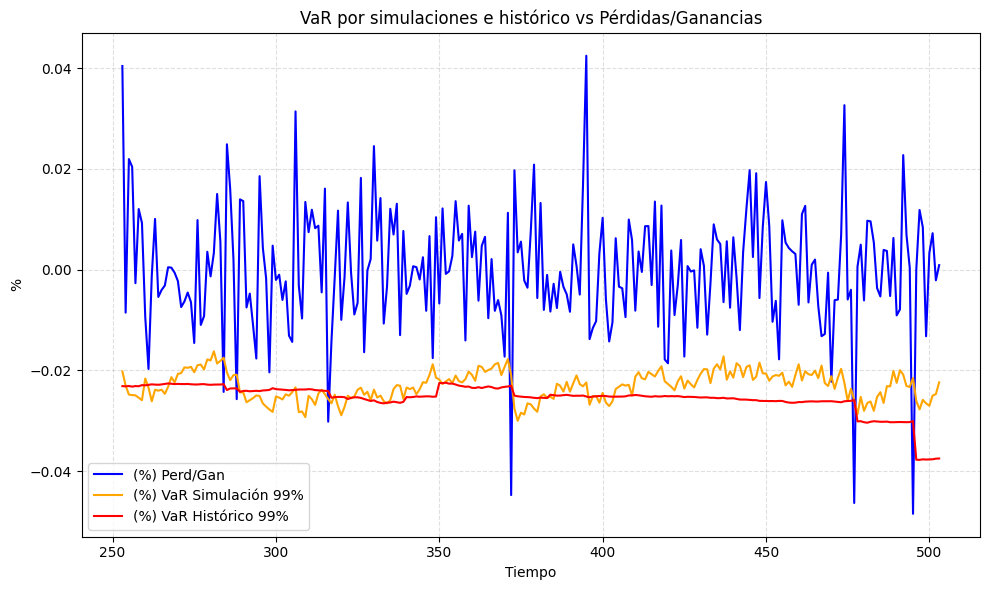

In [14]:
df_plot = df_final.dropna(subset=["(%) VaR histórico 99%", "(%) VaR simulación 99%"])
plt.figure(figsize=(10, 6))
plt.plot(df_plot["(%) Perd/Gan"], label="(%) Perd/Gan", color="blue")
plt.plot(df_plot["(%) VaR simulación 99%"], label="(%) VaR Simulación 99%", color="orange")
plt.plot(df_plot["(%) VaR histórico 99%"], label="(%) VaR Histórico 99%", color="red")
plt.xlabel("Tiempo")
plt.ylabel("%")
plt.title("VaR por simulaciones e histórico vs Pérdidas/Ganancias")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()